## Import all necessary modules

In [1]:
import numpy as np
import pandas as pd 
# everything necessary for the statistical analysis 
import pingouin as pg
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.formula.api as smf
import statsmodels.api as sm
# important for plotting
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/maria/miniconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load dataset

In [2]:
# load your excel table with all the needed information for the analysis 
data = pd.read_csv('/media/maria/Elements/Bipolife_BIDS/A1/derivatives/connectivity_matrices/subs/stattable_partialcorrelation_final.tsv', delimiter = "\t")                 

## Calculating the pvalues for the effect score for every connection with an OLS regression and sorting them by significance to find the most important ones
### IDSC

In [3]:
# create a new dataframe for the important connections and their calculated measures 
pval_depr = pd.DataFrame(columns = ['connection','coef','std err','pvalue','0.025','0.975'])

# loop over all possible connections and ignore the first 7 entries (demographical data)
for connection in data.columns[7:]:
    
    depr_pval = []
    
    # calculate the OLS regression, forumlar is based on R
    model = smf.ols(f"{connection} ~ 1 + idsc + sex + idsc:sex", data=data)
    results = model.fit()
    
    # we only want to get the p-values smaller than 0.01
    if results.pvalues['idsc'] < 0.01:
        intervalls = results.conf_int()
        depr_pval.extend([connection, results.params['idsc'], results.bse['idsc'], results.pvalues['idsc'], intervalls.iloc[2][0], intervalls.iloc[2][1]])
        pval_depr.loc[len(pval_depr)] = depr_pval

In [4]:
# sort the values according to significance and show them 
pval_depr_sorted = pval_depr.sort_values('pvalue')
pval_depr_sorted

,connection,coef,std err,pvalue,0.025,0.975
2,Parahippocampal_gyrus_LH_X__Angular_gyrus_post...,0.003055,0.000898,0.000750,0.001288,0.004821
1,Parahippocampal_gyrus_LH_X__Superior_frontal_s...,-0.002512,0.000813,0.002151,-0.004111,-0.000914
7,Amygdala_LH_X_Anterior_cingulate_cortex,-0.002880,0.000947,0.002539,-0.004743,-0.001017
4,Parahippocampal_gyrus_RH_X__Parahippocampal_gy...,0.002343,0.000778,0.002790,0.000813,0.003873
0,Middle_temporal_gyrus_LH_X_Posterior_cingulate...,0.002238,0.000763,0.003568,0.000738,0.003739
8,Hippocampus_anterior_RH_X__Pars_triangularis_LH,0.002539,0.000890,0.004606,0.000788,0.004290
6,Superior_frontal_sulcus_anterior_LH2_X_Parieto...,-0.002207,0.000788,0.005368,-0.003757,-0.000658
5,Pars_triangularis_RH_X_Posterior_cingulate_cor...,-0.002017,0.000742,0.006857,-0.003475,-0.000558
3,Parahippocampal_gyrus_RH_X__Superior_frontal_s...,0.002229,0.000833,0.007801,0.000591,0.003867


### YMRS (same procedure as for the IDSC)

In [5]:
pval_manic = pd.DataFrame(columns = ['connection','coef','std err','pvalue','0.025','0.975'])

# loop over all possible connections and ignore the first 7 entries (demographical data)
for connection in data.columns[7:]:
    
    manic_pval = []
    
    model = smf.ols(f"{connection} ~ 1 + ymrs + sex + ymrs:sex", data=data)
    results = model.fit()
    
    if results.pvalues['ymrs'] < 0.01:
        intervalls = results.conf_int()
        manic_pval.extend([connection, results.params['ymrs'], results.bse['ymrs'], results.pvalues['ymrs'], intervalls.iloc[2][0], intervalls.iloc[2][1]])
        pval_manic.loc[len(pval_manic)] = manic_pval

In [6]:
pval_manic_sorted = pval_manic.sort_values('pvalue')
pval_manic_sorted

,connection,coef,std err,pvalue,0.025,0.975
4,Superior_frontal_sulcus_anterior_LH2_X__Thalamus,0.010806,0.002892,0.000217,0.005118,0.016493
7,Hippocampus_anterior_RH_X__Ventromedial_prefro...,-0.009125,0.002543,0.000379,-0.014126,-0.004124
5,Angular_gyrus_inferior_RH_X_Middle_temporal_gy...,-0.010147,0.003126,0.001283,-0.016295,-0.003998
0,Dorsomedial_prefrontal_cortex_anteromedial_X_P...,0.008038,0.002533,0.001636,0.003057,0.013018
3,Superior_frontal_sulcus_anterior_LH2_X_Parieto...,-0.007401,0.002528,0.003632,-0.012372,-0.002430
2,Superior_frontal_sulcus_RH_X_Anterior_cingulat...,0.008824,0.003087,0.004507,0.002753,0.014895
1,Thalamus_X_Hippocampal_fissure,0.008780,0.003215,0.006625,0.002458,0.015102
6,Hippocampus_anterior_LH_X_Anterior_cingulate_c...,-0.008173,0.002992,0.006626,-0.014058,-0.002288


In [7]:
sign_cons_depr = list(pval_depr_sorted['connection'])
sign_cons_manic = list(pval_manic_sorted['connection'])

In [ ]:
# correct all p-values of the OLS regression for multiple comparisons and check if they stay significant
#from statsmodels.stats.multitest import multipletests
#multipletests(pval_depr_sorted['pvalue'], alpha=0.05, method='fdr_bh')[:2]
#multipletests(pval_manic_sorted['pvalue'], alpha=0.05, method='fdr_bh')[:2]

## Plotting the residuals of the OLS regression to see if the dependent variable has to be rank transformed
### if the plot of residuals shows outliers data has to be rank transformed 

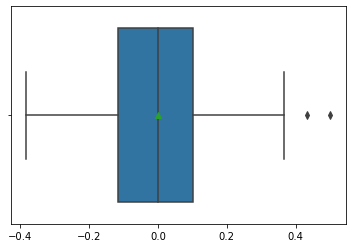

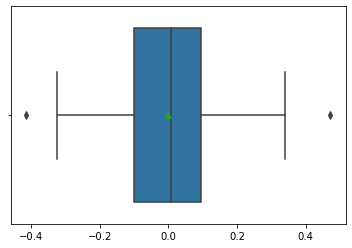

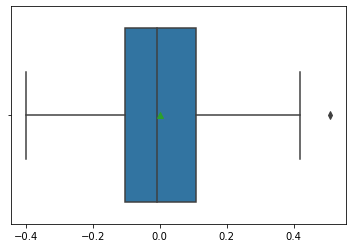

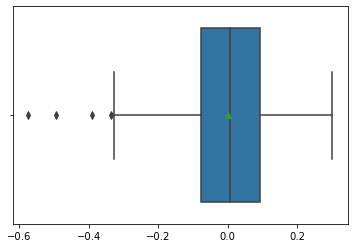

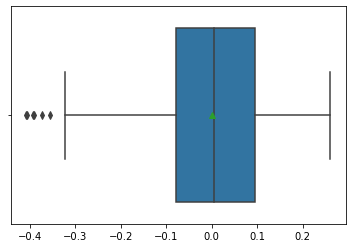

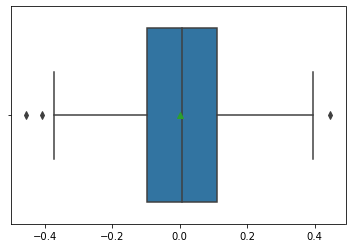

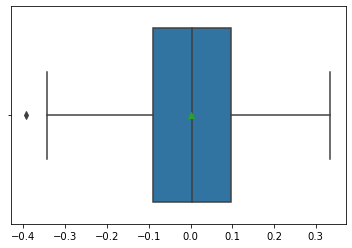

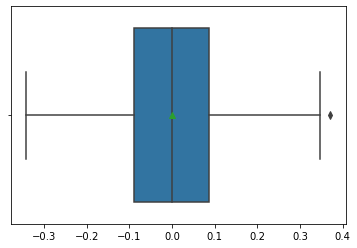

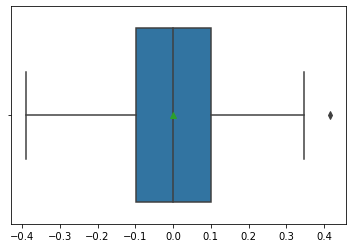

In [8]:
# IDSC
for connection in sign_cons_depr:

    model = smf.ols(f"{connection} ~ 1 + idsc + sex + idsc:sex ", data=data)
    results = model.fit()
    # plot the residuals
    sns.boxplot(x=results.resid, showmeans=True);
    plt.show()

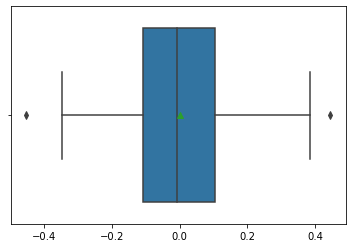

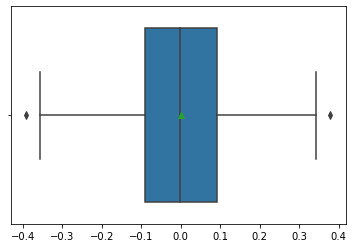

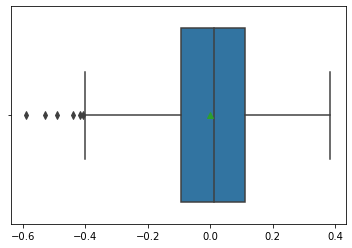

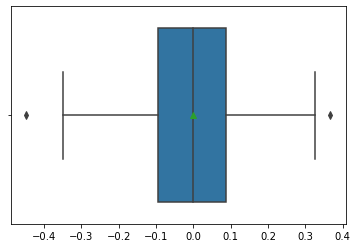

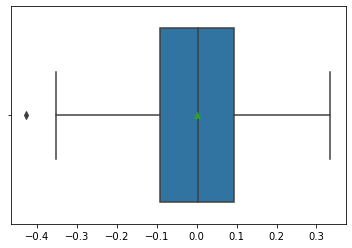

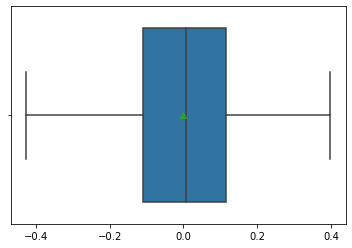

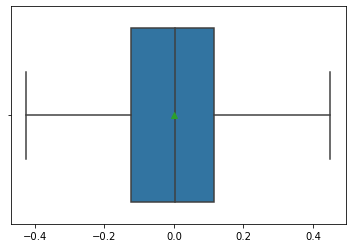

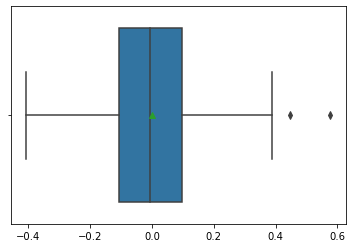

In [9]:
# ymrs 
for connection in sign_cons_manic:

    model = smf.ols(f"{connection} ~ 1 + ymrs + sex + ymrs:sex ", data=data)
    results = model.fit()
    #plot the residuals
    sns.boxplot(x=results.resid, showmeans=True);
    plt.show()

### Creating a new dataframe with the rank transformed values 

### IDSC

In [10]:
# create the columns of the table 
rank_col_depr = ['sub','sex','idsc'] # add necessary data 
# add all the significant connections
rank_col_depr.extend(sign_cons_depr) 
depr_rank = data[rank_col_depr]
#data_rank

# enter the ranked data into the table 
for connection in depr_rank.columns[3:]: # because the first 3 entries are demographical entries 
    # rank the data 
    depr_ranking = stats.rankdata(depr_rank[connection]) # possibilities = ‘average’, ‘min’, ‘max’, ‘first’, ‘dense’, average is default
    depr_rank[f'{connection}_rank'] = depr_ranking
depr_rank

<ipython-input-10-3d57969e61fc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depr_rank[f'{connection}_rank'] = depr_ranking


,sub,sex,idsc,Parahippocampal_gyrus_LH_X__Angular_gyrus_posterior_LH,Parahippocampal_gyrus_LH_X__Superior_frontal_sulcus_anterior_LH,Amygdala_LH_X_Anterior_cingulate_cortex,Parahippocampal_gyrus_RH_X__Parahippocampal_gyrus_LH,Middle_temporal_gyrus_LH_X_Posterior_cingulate_cortex,Hippocampus_anterior_RH_X__Pars_triangularis_LH,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior,...,Parahippocampal_gyrus_RH_X__Superior_frontal_sulcus_anterior_LH,Parahippocampal_gyrus_LH_X__Angular_gyrus_posterior_LH_rank,Parahippocampal_gyrus_LH_X__Superior_frontal_sulcus_anterior_LH_rank,Amygdala_LH_X_Anterior_cingulate_cortex_rank,Parahippocampal_gyrus_RH_X__Parahippocampal_gyrus_LH_rank,Middle_temporal_gyrus_LH_X_Posterior_cingulate_cortex_rank,Hippocampus_anterior_RH_X__Pars_triangularis_LH_rank,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior_rank,Pars_triangularis_RH_X_Posterior_cingulate_cortex_inferior_rank,Parahippocampal_gyrus_RH_X__Superior_frontal_sulcus_anterior_LH_rank
0,BC01,male,7.0,-0.025985,-0.124834,-0.151106,0.454720,-0.154857,-0.093886,0.020126,...,-0.119917,60.0,71.0,103.0,182.0,19.0,104.0,223.0,286.0,107.0
1,BC02,male,4.0,0.290396,0.142551,0.111351,0.444134,-0.120354,-0.025338,-0.031309,...,-0.118945,302.0,311.0,299.0,173.0,26.0,159.0,173.0,303.0,108.0
2,BC03,female,7.0,0.093108,-0.121462,-0.011353,0.363157,0.259614,0.083484,-0.025568,...,0.052619,157.0,74.0,228.0,89.0,339.0,259.0,180.0,216.0,260.0
3,BC04,female,8.0,0.387216,0.181153,-0.034843,0.532082,-0.034660,0.064270,0.232458,...,-0.018157,346.0,331.0,210.0,259.0,74.0,246.0,348.0,253.0,196.0
4,BC05,female,4.0,0.309229,-0.120263,0.069818,0.418257,0.156738,-0.264848,-0.026650,...,0.061564,313.0,77.0,277.0,150.0,271.0,19.0,178.0,127.0,267.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,TR02,female,15.0,0.006037,-0.169680,0.205360,0.422618,0.079163,0.004050,-0.002127,...,0.148350,82.0,44.0,342.0,156.0,191.0,198.0,201.0,326.0,324.0
356,TR03,male,14.0,0.284149,-0.068368,-0.045211,0.365221,0.075328,-0.103497,0.039827,...,0.181530,293.0,116.0,196.0,91.0,185.0,93.0,240.0,273.0,342.0
357,TS03,female,8.0,0.016617,-0.065881,0.290501,0.411280,-0.361601,-0.258904,-0.016579,...,0.129968,87.0,119.0,356.0,141.0,1.0,22.0,187.0,353.0,316.0
358,TS04,male,0.0,0.026317,-0.039567,-0.261752,0.532582,0.006761,-0.111579,-0.052353,...,-0.145978,93.0,144.0,34.0,261.0,109.0,88.0,146.0,255.0,79.0


In [11]:
# same procedure as before to get the pvalues and other measures from the OLS regression but this time based on the rank transformed data 
pval_rank_depr = pd.DataFrame(columns = ['connection','coef','std err','pvalue','0.025','0.975'])

# loop over all possible connections and ignore the first 3 entries (demographical data)
for connection in depr_rank.columns[3:]:
    if ('rank' in connection) ==  True: # to only get the ranked columns
    
        depr_pval = []

        model = smf.ols(f"{connection} ~ 1 + idsc + sex + idsc:sex", data=depr_rank)
        results = model.fit()

        intervalls = results.conf_int()
        depr_pval.extend([connection, results.params['idsc'], results.bse['idsc'], results.pvalues['idsc'], intervalls.iloc[2][0], intervalls.iloc[2][1]])
        pval_rank_depr.loc[len(pval_rank_depr)] = depr_pval
        
# save the values as a tsv file to have them separately 
pval_rank_depr.to_csv('/media/sf_shared_VB/MA_results/ranked_signcons_idsc_ols.tsv', sep='\t', index=False) 

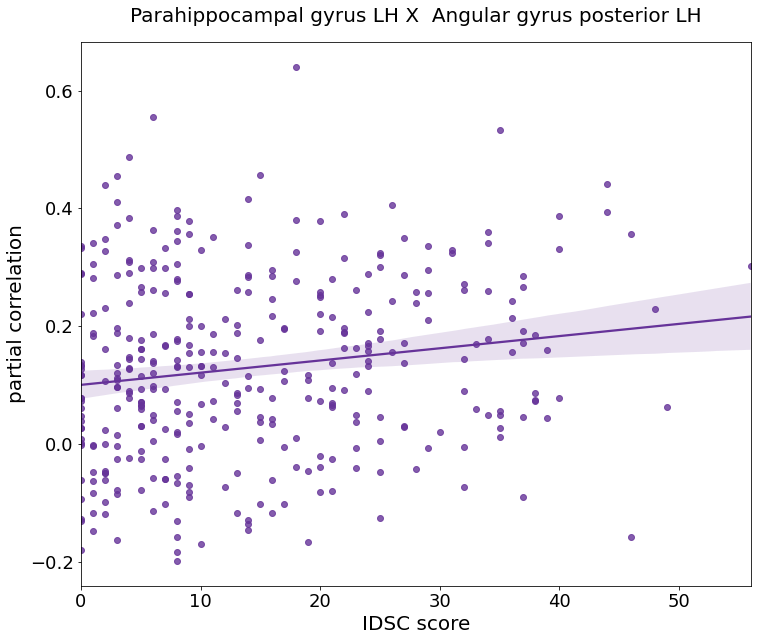

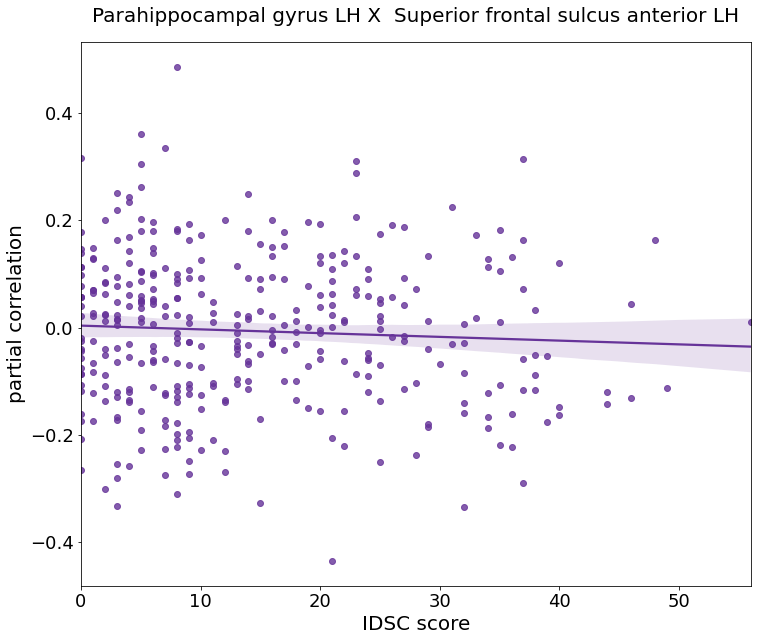

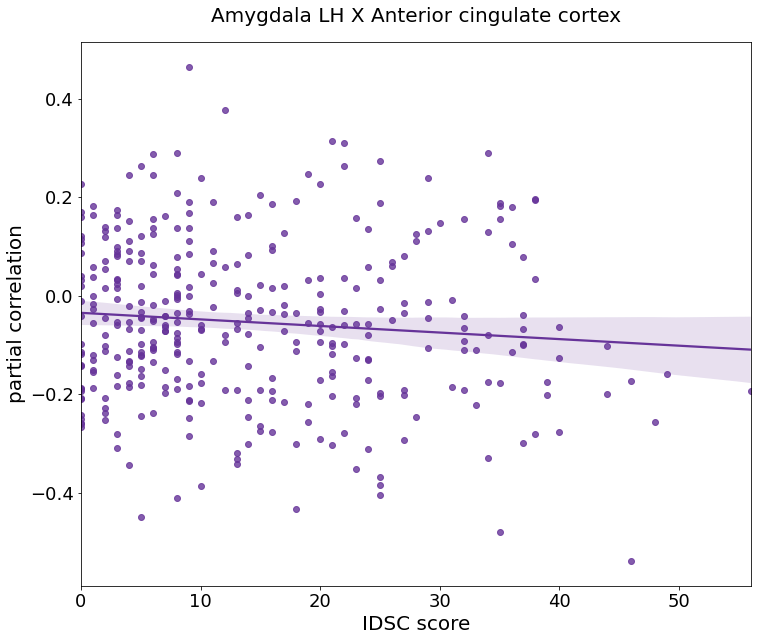

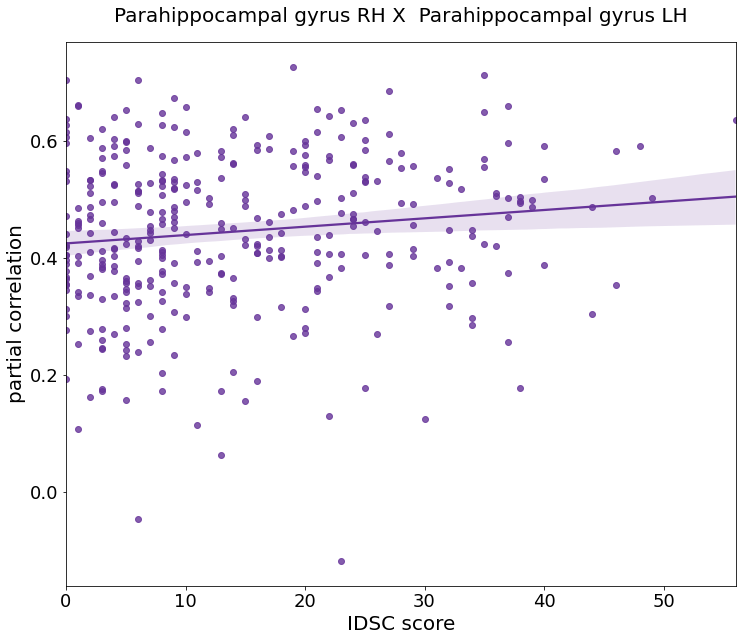

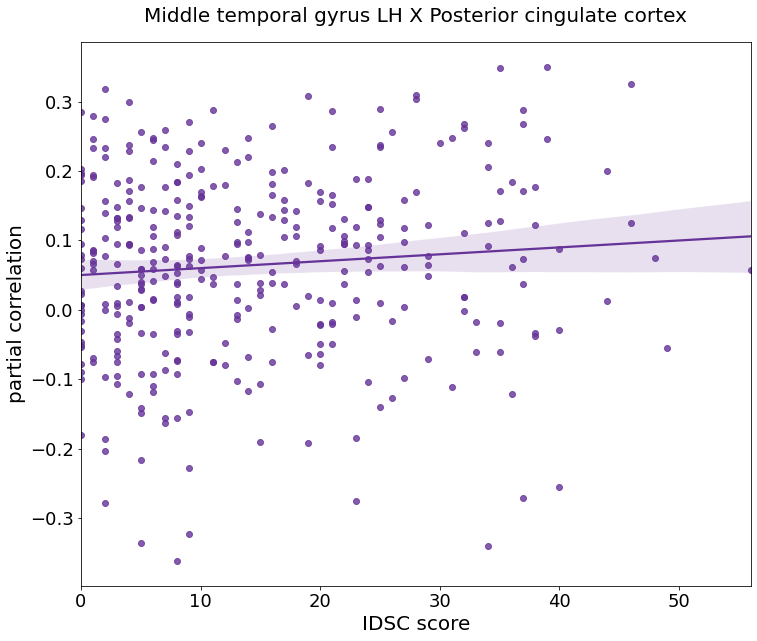

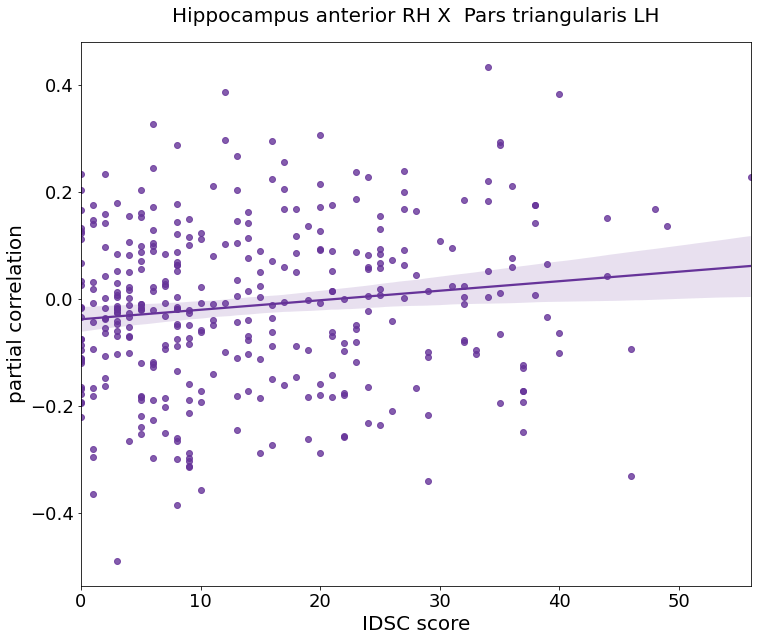

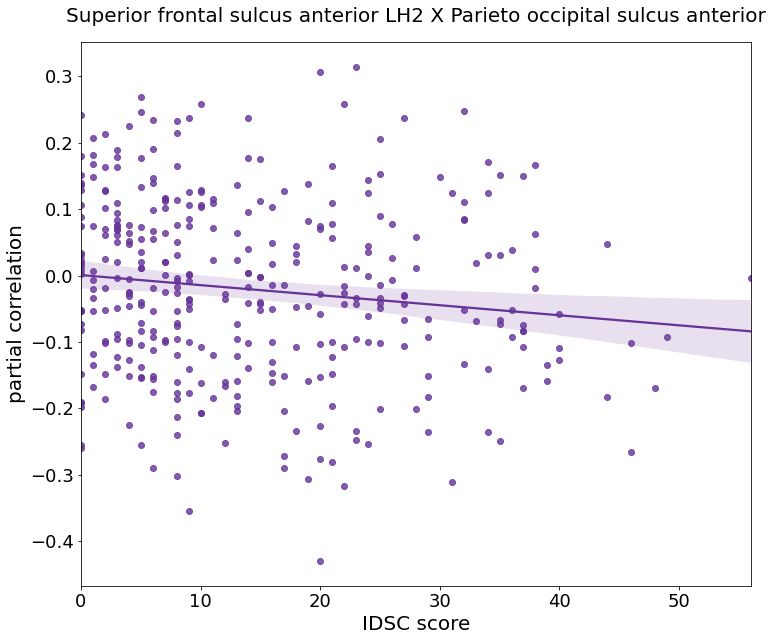

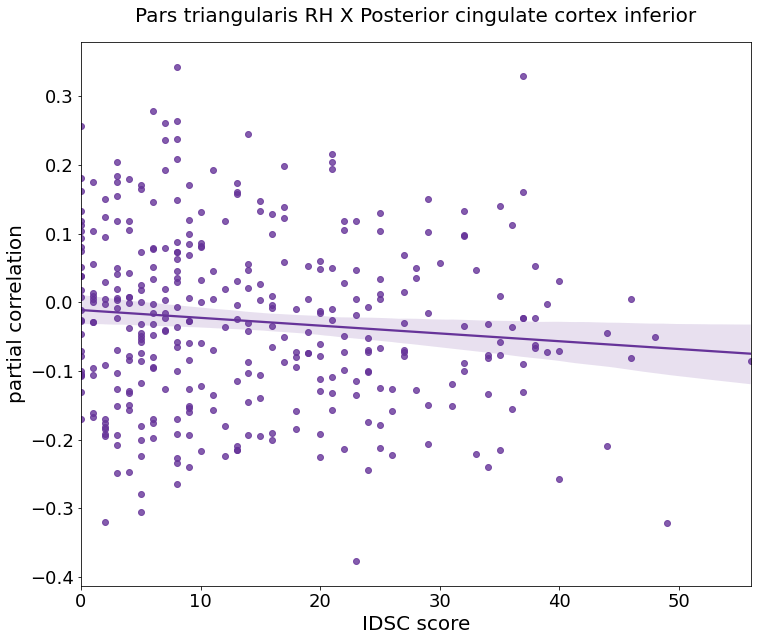

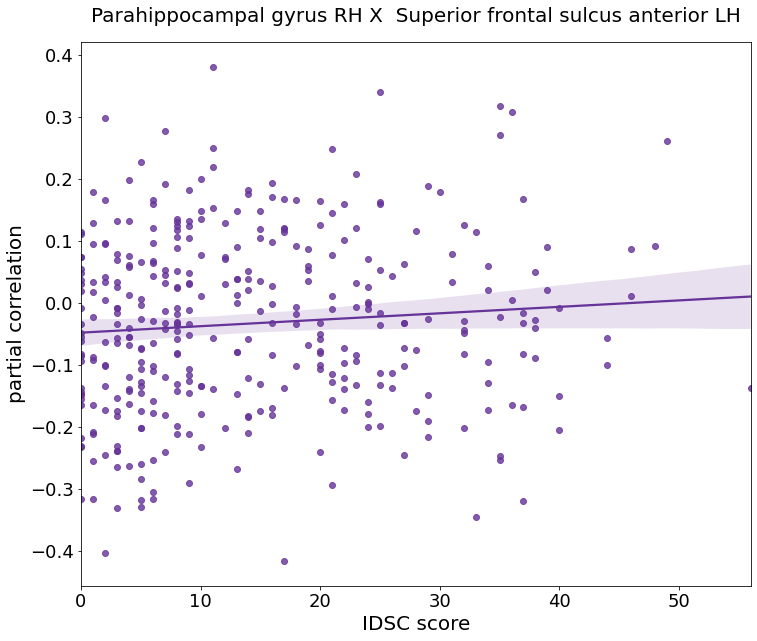

In [18]:
# create a regression plot based on the NOT rank transformed data
for connection in sign_cons_depr:

    plt.figure(figsize=(12, 10))

    ax = sns.regplot(x = 'idsc', y = connection, data = data, color = 'rebeccapurple')

    # costumize the legend, fontsizes, labels, title
    plt.title(connection.replace('_',' '), fontsize = 20, pad = 20)
    ax.set_ylabel('partial correlation', fontsize = 20)
    ax.set_xlabel('IDSC score', fontsize = 20)
    plt.yticks(fontsize = 18)
    plt.xticks(fontsize = 18)
    plt.savefig(f'/media/sf_shared_VB/MA_results/idsc_{connection}_plot.png')

### YMRS (same procedure as for IDSC)

In [19]:
# create the columns of the table 
rank_col_manic = ['sub','sex','ymrs'] # add demographical data 
rank_col_manic.extend(sign_cons_manic) # add all the significant connections
manic_rank = data[rank_col_manic]
#manic_rank

for connection in manic_rank.columns[3:]:
    manic_ranking = stats.rankdata(manic_rank[connection])
    # possibilities = ‘average’, ‘min’, ‘max’, ‘first’, ‘dense’, average is default
    manic_rank[f'{connection}_rank'] = manic_ranking
manic_rank

<ipython-input-19-49521e71cc3a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manic_rank[f'{connection}_rank'] = manic_ranking


,sub,sex,ymrs,Superior_frontal_sulcus_anterior_LH2_X__Thalamus,Hippocampus_anterior_RH_X__Ventromedial_prefrontal_cortex_anterior,Angular_gyrus_inferior_RH_X_Middle_temporal_gyrus_RH,Dorsomedial_prefrontal_cortex_anteromedial_X_Posterior_cingulate_cortex,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior,Superior_frontal_sulcus_RH_X_Anterior_cingulate_cortex,Thalamus_X_Hippocampal_fissure,Hippocampus_anterior_LH_X_Anterior_cingulate_cortex,Superior_frontal_sulcus_anterior_LH2_X__Thalamus_rank,Hippocampus_anterior_RH_X__Ventromedial_prefrontal_cortex_anterior_rank,Angular_gyrus_inferior_RH_X_Middle_temporal_gyrus_RH_rank,Dorsomedial_prefrontal_cortex_anteromedial_X_Posterior_cingulate_cortex_rank,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior_rank,Superior_frontal_sulcus_RH_X_Anterior_cingulate_cortex_rank,Thalamus_X_Hippocampal_fissure_rank,Hippocampus_anterior_LH_X_Anterior_cingulate_cortex_rank
0,BC01,male,0.0,-0.356743,-0.007655,0.227359,0.053275,0.020126,0.076304,0.007003,0.051132,5.0,156.0,234.0,208.0,223.0,182.0,106.0,224.0
1,BC02,male,0.0,0.169153,0.313488,0.471625,0.028254,-0.031309,0.190328,0.190821,-0.196369,321.0,357.0,357.0,178.0,173.0,269.0,232.0,37.0
2,BC03,female,0.0,0.109474,0.296882,-0.024013,-0.126678,-0.025568,-0.082205,0.017526,-0.104569,289.0,355.0,54.0,51.0,180.0,65.0,113.0,89.0
3,BC04,female,0.0,-0.149823,-0.058622,-0.180156,-0.011288,0.232458,0.144388,-0.115567,0.209542,83.0,101.0,14.0,138.0,348.0,232.0,40.0,321.0
4,BC05,female,0.0,-0.218137,0.288085,0.342636,-0.132858,-0.026650,-0.222736,0.024086,0.073435,33.0,352.0,320.0,46.0,178.0,15.0,121.0,246.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,TR02,female,0.0,0.120387,0.142750,0.279264,0.069227,-0.002127,0.408164,-0.047407,-0.022425,299.0,295.0,283.0,229.0,201.0,353.0,69.0,158.0
356,TR03,male,4.0,-0.123835,0.008493,-0.101531,0.150480,0.039827,0.086238,0.147584,0.066024,104.0,176.0,29.0,298.0,240.0,187.0,204.0,239.0
357,TS03,female,0.0,-0.182985,0.113680,0.292125,0.359422,-0.016579,0.020879,-0.290068,0.112968,57.0,270.0,287.0,358.0,187.0,142.0,4.0,271.0
358,TS04,male,2.0,-0.054053,-0.028123,0.070007,0.111532,-0.052353,0.256183,0.186564,0.067431,159.0,129.0,95.0,268.0,146.0,316.0,228.0,242.0


In [20]:
pval_rank_manic = pd.DataFrame(columns = ['connection','coef','std err','pvalue','0.025','0.975'])

# loop over all possible connections and ignore the first 7 entries (demographical data)
for connection in manic_rank.columns[3:]:
    if ('rank' in connection) ==  True: # to only get the ranked columns
    
        manic_pval = []

        model = smf.ols(f"{connection} ~ 1 + ymrs + sex + ymrs:sex", data=manic_rank)
        results = model.fit()

        intervalls = results.conf_int()
        manic_pval.extend([connection, results.params['ymrs'], results.bse['ymrs'], results.pvalues['ymrs'], intervalls.iloc[2][0], intervalls.iloc[2][1]])
        pval_rank_manic.loc[len(pval_rank_manic)] = manic_pval
        
# save the values as a tsv file to have them separately 
pval_rank_manic.to_csv('/media/sf_shared_VB/MA_results/ranked_signcons_ymrs_ols.tsv', sep='\t', index=False) 

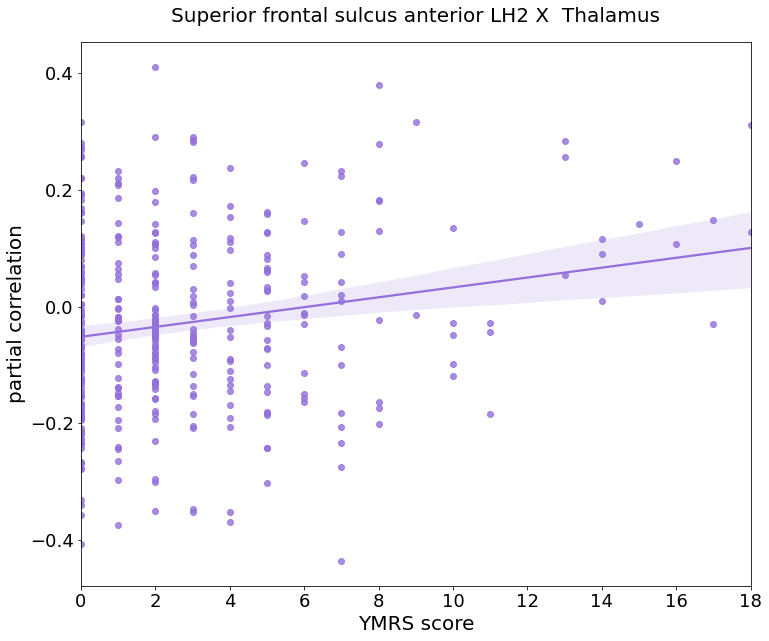

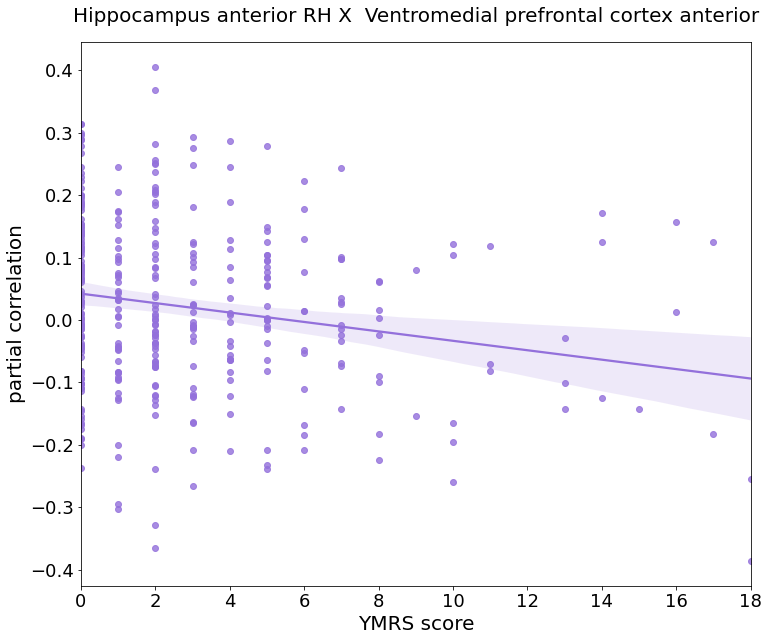

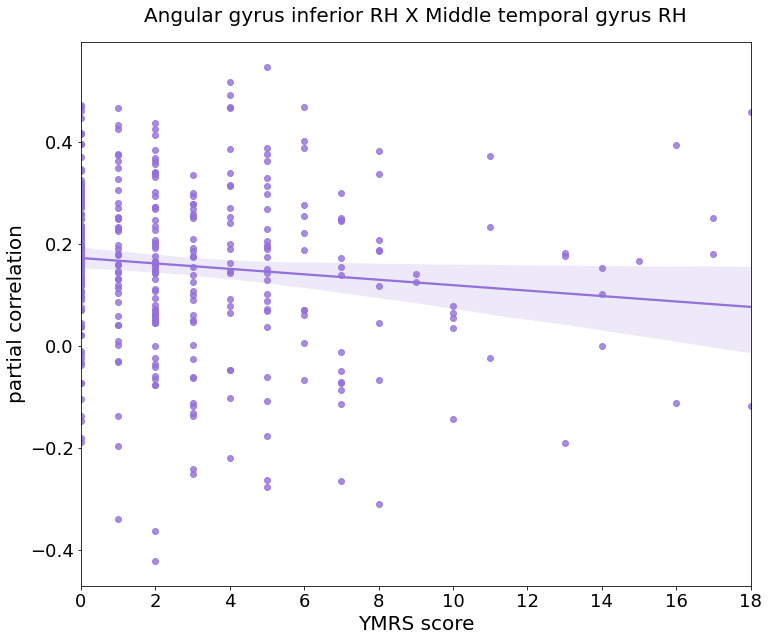

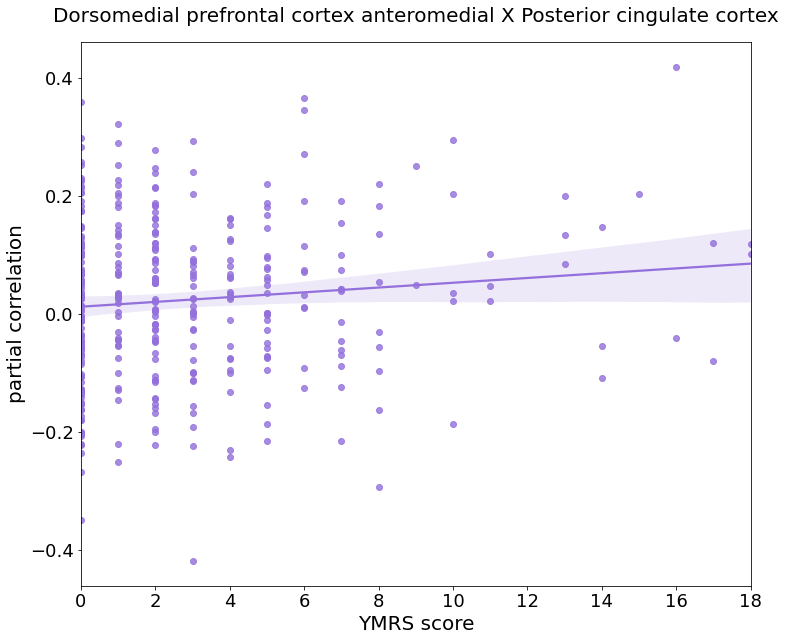

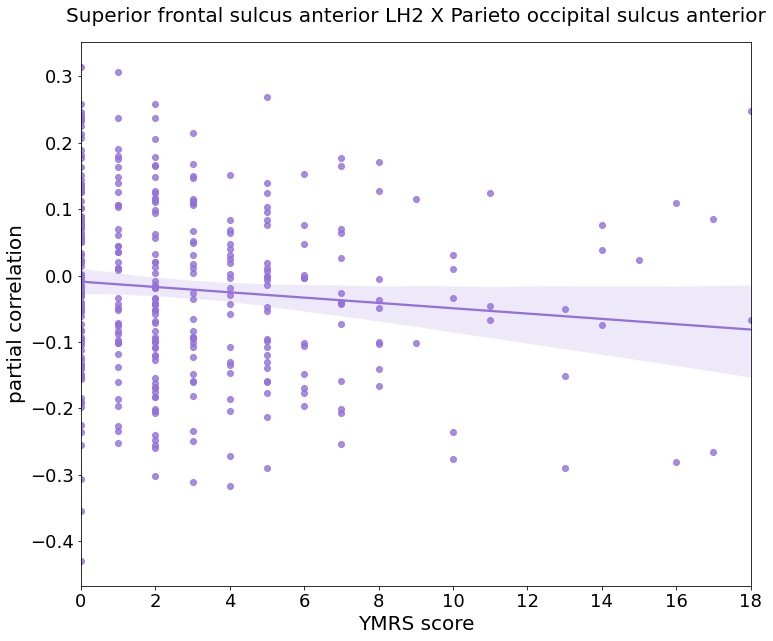

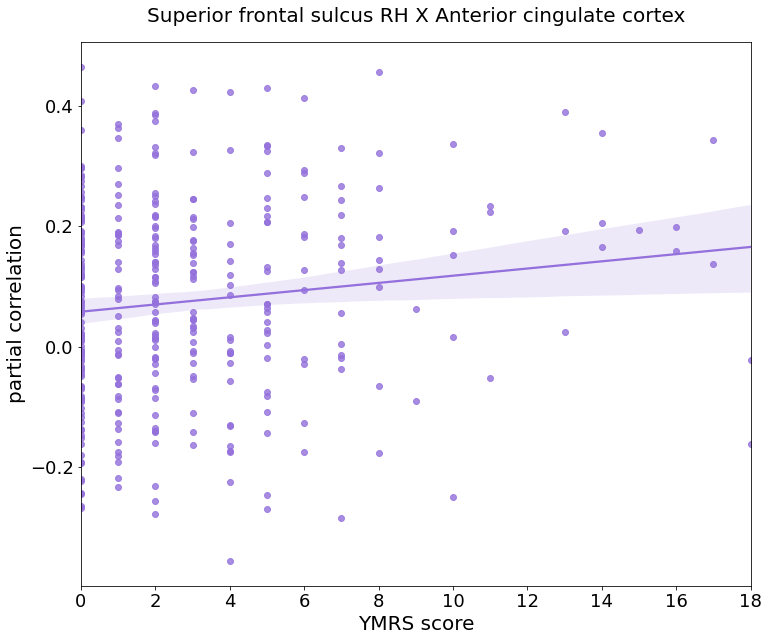

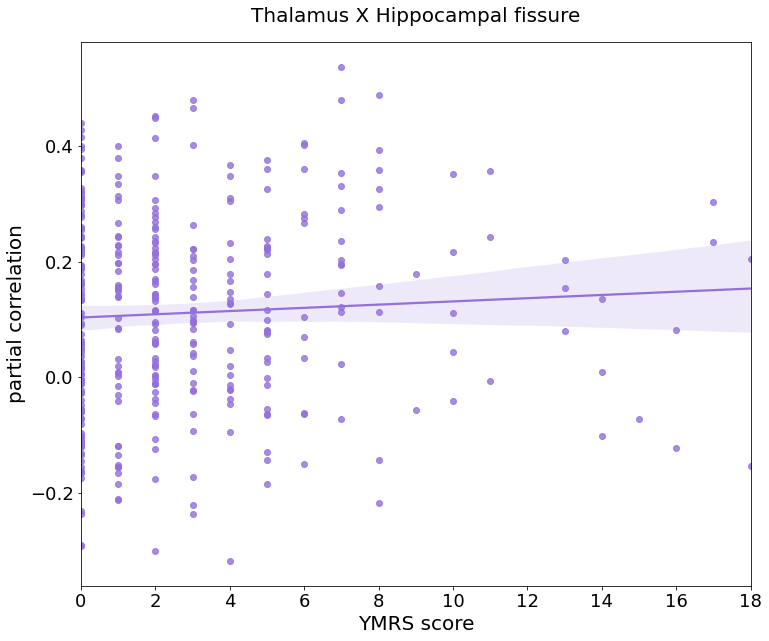

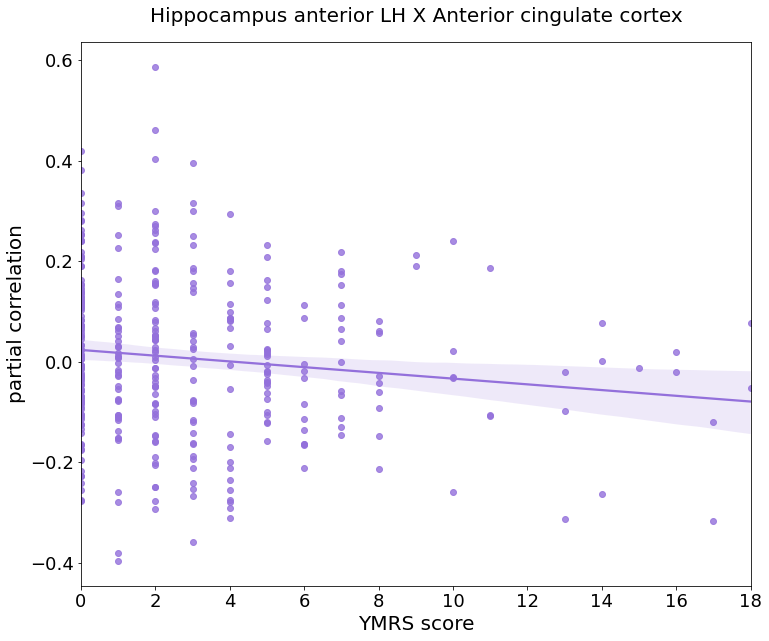

In [21]:
for connection in sign_cons_manic:

    plt.figure(figsize=(12, 10))

    ax = sns.regplot(x = 'ymrs', y = connection, data = data, color = 'mediumpurple')

    # costumize the legend, fontsizes, labels, title
    plt.title(connection.replace('_',' '), fontsize = 20, pad = 20)
    ax.set_ylabel('partial correlation', fontsize = 20)
    ax.set_xlabel('YMRS score', fontsize = 20)
    plt.yticks(fontsize = 18)
    plt.xticks(fontsize = 18)
    plt.savefig(f'/media/sf_shared_VB/MA_results/ymrs_{connection}_plot.png')

## Calculate the OLS for the most significant connections and check for sex interactions (rank transformed data)
### IDSC

#### Calculate the rank transformed data and check for interaction of IDSC and sex for the most significant connections

In [23]:
pval_depr = pd.DataFrame(columns = ['connection','coef','std err','pvalue','0.025','0.975'])
sexdif_rank_depr = pd.DataFrame(columns = ['connection','coef','std err','pvalue','0.025','0.975'])

sexdif_cons_depr = []
# loop over all possible connections and ignore the first 7 entries (demographical data)
for connection in depr_rank.columns[3:]:
    if ('rank' in connection) ==  True:
    
        depr_pval = []
        sexdif_vals = []

        model = smf.ols(f"{connection} ~ 1 + idsc + sex + idsc:sex", data=depr_rank)
        results = model.fit()

        if results.pvalues['idsc'] < 0.01:
            intervalls = results.conf_int()
            depr_pval.extend([connection, results.params['idsc'], results.bse['idsc'], results.pvalues['idsc'], intervalls.iloc[2][0], intervalls.iloc[2][1]])
            pval_depr.loc[len(pval_depr)] = depr_pval
            
        if results.pvalues['idsc:sex[T.male]'] < 0.01:   
            intervalls = results.conf_int()
            sexdif_vals.extend([connection, results.params['idsc:sex[T.male]'], results.bse['idsc:sex[T.male]'], results.pvalues['idsc:sex[T.male]'], intervalls.iloc[3][0], intervalls.iloc[3][1]])
            sexdif_rank_depr.loc[len(sexdif_rank_depr)] = sexdif_vals
            
            sexdif_cons_depr.append(connection)
            print(connection, results.pvalues['idsc:sex[T.male]'])
            
# save the values as a tsv file to have them separately 
sexdif_rank_depr.to_csv('/media/sf_shared_VB/MA_results/ranked_sexdif_idsc_ols.tsv', sep='\t', index=False) 

Parahippocampal_gyrus_LH_X__Superior_frontal_sulcus_anterior_LH_rank 0.0016858668551949622
Amygdala_LH_X_Anterior_cingulate_cortex_rank 0.005819455350300766


### Separate the data according to sex and calculate the OLS regression for both sexes
#### female participants

In [24]:
# data including only females 
data_female_depr = depr_rank[depr_rank.sex != 'male']

# drop the old ranks because they are based on the overall data and not on the specific sex 
old_ranks = ['Parahippocampal_gyrus_LH_X__Angular_gyrus_posterior_LH_rank',
       'Parahippocampal_gyrus_LH_X__Superior_frontal_sulcus_anterior_LH_rank',
       'Amygdala_LH_X_Anterior_cingulate_cortex_rank',
       'Parahippocampal_gyrus_RH_X__Parahippocampal_gyrus_LH_rank',
       'Middle_temporal_gyrus_LH_X_Posterior_cingulate_cortex_rank',
       'Hippocampus_anterior_RH_X__Pars_triangularis_LH_rank',
       'Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior_rank',
       'Pars_triangularis_RH_X_Posterior_cingulate_cortex_inferior_rank',
       'Parahippocampal_gyrus_RH_X__Superior_frontal_sulcus_anterior_LH_rank']

data_female_depr.drop(old_ranks, inplace = True, axis = 1)

for cons in data_female_depr.columns[3:]: # ignore the first 3 columns
    
    #rank the data 
    ranking = stats.rankdata(data_female_depr[cons])# possibilities = ‘average’, ‘min’, ‘max’, ‘first’, ‘dense’, average is default
    # create new columns for the ranked data 
    data_female_depr[f'{cons}_rank'] = ranking

data_female_depr

/home/maria/.local/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-24-ad957585c97a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_female_depr[f'{cons}_rank'] = ranking


,sub,sex,idsc,Parahippocampal_gyrus_LH_X__Angular_gyrus_posterior_LH,Parahippocampal_gyrus_LH_X__Superior_frontal_sulcus_anterior_LH,Amygdala_LH_X_Anterior_cingulate_cortex,Parahippocampal_gyrus_RH_X__Parahippocampal_gyrus_LH,Middle_temporal_gyrus_LH_X_Posterior_cingulate_cortex,Hippocampus_anterior_RH_X__Pars_triangularis_LH,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior,...,Parahippocampal_gyrus_RH_X__Superior_frontal_sulcus_anterior_LH,Parahippocampal_gyrus_LH_X__Angular_gyrus_posterior_LH_rank,Parahippocampal_gyrus_LH_X__Superior_frontal_sulcus_anterior_LH_rank,Amygdala_LH_X_Anterior_cingulate_cortex_rank,Parahippocampal_gyrus_RH_X__Parahippocampal_gyrus_LH_rank,Middle_temporal_gyrus_LH_X_Posterior_cingulate_cortex_rank,Hippocampus_anterior_RH_X__Pars_triangularis_LH_rank,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior_rank,Pars_triangularis_RH_X_Posterior_cingulate_cortex_inferior_rank,Parahippocampal_gyrus_RH_X__Superior_frontal_sulcus_anterior_LH_rank
2,BC03,female,7.0,0.093108,-0.121462,-0.011353,0.363157,0.259614,0.083484,-0.025568,...,0.052619,84.0,36.0,123.0,47.0,170.0,132.0,92.0,110.0,130.0
3,BC04,female,8.0,0.387216,0.181153,-0.034843,0.532082,-0.034660,0.064270,0.232458,...,-0.018157,176.0,170.0,110.0,137.0,40.0,123.0,179.0,124.0,94.0
4,BC05,female,4.0,0.309229,-0.120263,0.069818,0.418257,0.156738,-0.264848,-0.026650,...,0.061564,155.0,38.0,151.0,85.0,139.0,8.0,91.0,65.0,136.0
6,BC07,female,8.0,0.132498,0.083320,-0.119321,0.373614,-0.071801,0.286920,-0.240384,...,-0.080554,94.0,135.0,68.0,50.0,28.0,175.0,14.0,48.0,72.0
7,BC08,female,1.0,-0.002878,0.127707,-0.000449,0.661177,0.085314,0.175629,-0.118620,...,-0.211265,40.0,155.0,128.0,181.0,103.0,157.0,48.0,172.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,TD07,female,40.0,0.386934,-0.162685,-0.276769,0.535400,-0.254956,0.382424,-0.058277,...,-0.007749,175.0,23.0,14.0,140.0,4.0,182.0,70.0,121.0,102.0
353,TF02,female,6.0,0.049049,-0.110016,-0.134242,0.511394,0.119229,-0.225140,0.098463,...,-0.304985,66.0,45.0,61.0,130.0,122.0,15.0,144.0,62.0,7.0
354,TF03,female,5.0,0.065346,0.046767,-0.180582,0.599297,0.147051,-0.119575,-0.104890,...,-0.024944,71.0,116.0,43.0,164.0,136.0,38.0,53.0,68.0,91.0
355,TR02,female,15.0,0.006037,-0.169680,0.205360,0.422618,0.079163,0.004050,-0.002127,...,0.148350,43.0,21.0,178.0,89.0,101.0,98.0,106.0,161.0,163.0


#### male participants

In [25]:
# data including only males 
data_male_depr = depr_rank[depr_rank.sex != 'female']

# drop the old ranks because they are based on the overall data and not on the specific sex 
old_ranks = ['Parahippocampal_gyrus_LH_X__Angular_gyrus_posterior_LH_rank',
       'Parahippocampal_gyrus_LH_X__Superior_frontal_sulcus_anterior_LH_rank',
       'Amygdala_LH_X_Anterior_cingulate_cortex_rank',
       'Parahippocampal_gyrus_RH_X__Parahippocampal_gyrus_LH_rank',
       'Middle_temporal_gyrus_LH_X_Posterior_cingulate_cortex_rank',
       'Hippocampus_anterior_RH_X__Pars_triangularis_LH_rank',
       'Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior_rank',
       'Pars_triangularis_RH_X_Posterior_cingulate_cortex_inferior_rank',
       'Parahippocampal_gyrus_RH_X__Superior_frontal_sulcus_anterior_LH_rank']

data_male_depr.drop(old_ranks, inplace = True, axis = 1)

for cons in data_male_depr.columns[3:]: # ignore the first 3 columns
    
    #rank the data 
    ranking = stats.rankdata(data_male_depr[cons])# possibilities = ‘average’, ‘min’, ‘max’, ‘first’, ‘dense’, average is default
    # create new columns for the ranked data 
    data_male_depr[f'{cons}_rank'] = ranking

data_male_depr

/home/maria/.local/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-25-7d03270458ec>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_male_depr[f'{cons}_rank'] = ranking


,sub,sex,idsc,Parahippocampal_gyrus_LH_X__Angular_gyrus_posterior_LH,Parahippocampal_gyrus_LH_X__Superior_frontal_sulcus_anterior_LH,Amygdala_LH_X_Anterior_cingulate_cortex,Parahippocampal_gyrus_RH_X__Parahippocampal_gyrus_LH,Middle_temporal_gyrus_LH_X_Posterior_cingulate_cortex,Hippocampus_anterior_RH_X__Pars_triangularis_LH,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior,...,Parahippocampal_gyrus_RH_X__Superior_frontal_sulcus_anterior_LH,Parahippocampal_gyrus_LH_X__Angular_gyrus_posterior_LH_rank,Parahippocampal_gyrus_LH_X__Superior_frontal_sulcus_anterior_LH_rank,Amygdala_LH_X_Anterior_cingulate_cortex_rank,Parahippocampal_gyrus_RH_X__Parahippocampal_gyrus_LH_rank,Middle_temporal_gyrus_LH_X_Posterior_cingulate_cortex_rank,Hippocampus_anterior_RH_X__Pars_triangularis_LH_rank,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior_rank,Pars_triangularis_RH_X_Posterior_cingulate_cortex_inferior_rank,Parahippocampal_gyrus_RH_X__Superior_frontal_sulcus_anterior_LH_rank
0,BC01,male,7.0,-0.025985,-0.124834,-0.151106,0.454720,-0.154857,-0.093886,0.020126,...,-0.119917,28.0,37.0,47.0,79.0,8.0,57.0,110.0,148.0,52.0
1,BC02,male,4.0,0.290396,0.142551,0.111351,0.444134,-0.120354,-0.025338,-0.031309,...,-0.118945,154.0,153.0,140.0,74.0,13.0,81.0,85.0,155.0,53.0
5,BC06,male,3.0,0.196805,-0.129068,0.098634,0.381871,-0.041613,0.007432,-0.048752,...,0.033439,130.0,34.0,136.0,50.0,33.0,102.0,76.0,5.0,120.0
8,BC09,male,5.0,0.161907,-0.066237,-0.449023,0.280933,0.004856,0.070424,-0.083542,...,-0.174097,113.0,60.0,1.0,21.0,54.0,125.0,59.0,2.0,27.0
9,BC10,male,0.0,0.007773,0.139890,0.160593,0.277401,0.284849,0.122268,-0.258987,...,-0.137261,40.0,152.0,155.0,17.0,173.0,147.0,4.0,145.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,TD03,male,31.0,0.324864,0.224954,-0.009812,0.383702,-0.110516,0.095102,0.123840,...,0.078906,160.0,171.0,106.0,51.0,14.0,135.0,147.0,39.0,141.0
349,TD04,male,20.0,0.191133,-0.003821,-0.071890,0.594426,-0.078797,0.092662,-0.027492,...,0.164718,126.0,88.0,79.0,154.0,22.0,134.0,86.0,96.0,166.0
356,TR03,male,14.0,0.284149,-0.068368,-0.045211,0.365221,0.075328,-0.103497,0.039827,...,0.181530,150.0,58.0,95.0,43.0,87.0,49.0,120.0,139.0,170.0
358,TS04,male,0.0,0.026317,-0.039567,-0.261752,0.532582,0.006761,-0.111579,-0.052353,...,-0.145978,43.0,70.0,17.0,124.0,56.0,46.0,73.0,131.0,37.0


### Get the sexdif results for IDSC in a table 

In [26]:
# dataframe for sign connections with sex differences 
sexdif_comparison_depr = pd.DataFrame(columns = ['connection','coef_f','std_err_f','pvalue_f','0.025_f','0.975_f','coef_m','std_err_m','pvalue_m','0.025_m','0.975_m'])

for connection in sexdif_cons_depr: # only for the connections showing sex differences 
        
        sexdif_vals_depr = []
        
        # female
        model_f = smf.ols(f"{connection} ~ 1 + idsc", data=data_female_depr)
        results_f = model_f.fit()
        # male
        model_m = smf.ols(f"{connection} ~ 1 + idsc", data=data_male_depr)
        results_m = model_m.fit()
        
        # to get the intervall from the results 
        intervalls_f = results_f.conf_int()
        intervalls_m = results_m.conf_int()
        
        sexdif_vals_depr.extend([connection, results_f.params['idsc'], results_f.bse['idsc'], results_f.pvalues['idsc'], intervalls_f.iloc[1][0], intervalls_f.iloc[1][1], results_m.params['idsc'], results_m.bse['idsc'], results_m.pvalues['idsc'], intervalls_m.iloc[1][0], intervalls_m.iloc[1][1]])
        sexdif_comparison_depr.loc[len(sexdif_comparison_depr)] = sexdif_vals_depr
            
            
# save the values as a tsv file to have them separately 
sexdif_comparison_depr.to_csv('/media/sf_shared_VB/MA_results/comparison_sexdif_idsc_ols.tsv', sep='\t', index=False) 
sexdif_comparison_depr

,connection,coef_f,std_err_f,pvalue_f,0.025_f,0.975_f,coef_m,std_err_m,pvalue_m,0.025_m,0.975_m
0,Parahippocampal_gyrus_LH_X__Superior_frontal_s...,-0.952255,0.307858,0.002296,-1.559729,-0.344781,0.531446,0.347478,0.127972,-0.154369,1.217261
1,Amygdala_LH_X_Anterior_cingulate_cortex_rank,-1.031771,0.304374,0.000859,-1.632370,-0.431171,0.335658,0.348873,0.337325,-0.352910,1.024226


### YMRS (same procedure as IDSC)
#### Calculate the rank transformed data and check for interaction of IDSC and sex for the most significant connections

In [27]:
pval_manic = pd.DataFrame(columns = ['connection','coef','std err','pvalue','0.025','0.975'])
sexdif_rank_manic = pd.DataFrame(columns = ['connection','coef','std err','pvalue','0.025','0.975'])

sexdif_cons_manic = []
# loop over all possible connections and ignore the first 7 entries (demographical data)
for connection in manic_rank.columns[3:]:
    if ('rank' in connection) ==  True:
    
        manic_pval = []
        sexdif_vals = []

        model = smf.ols(f"{connection} ~ 1 + ymrs + sex + ymrs:sex", data=manic_rank)
        results = model.fit()

        if results.pvalues['ymrs'] < 0.01:
            intervalls = results.conf_int()
            manic_pval.extend([connection, results.params['ymrs'], results.bse['ymrs'], results.pvalues['ymrs'], intervalls.iloc[2][0], intervalls.iloc[2][1]])
            pval_manic.loc[len(pval_manic)] = manic_pval
            
        if results.pvalues['ymrs:sex[T.male]'] < 0.01:   
            intervalls = results.conf_int()
            sexdif_vals.extend([connection, results.params['ymrs:sex[T.male]'], results.bse['ymrs:sex[T.male]'], results.pvalues['ymrs:sex[T.male]'], intervalls.iloc[3][0], intervalls.iloc[3][1]])
            sexdif_rank_manic.loc[len(sexdif_rank_manic)] = sexdif_vals
            
            sexdif_cons_manic.append(connection)
            print(connection, results.pvalues['ymrs:sex[T.male]'])
            
# save the values as a tsv file to have them separately 
sexdif_rank_manic.to_csv('/media/sf_shared_VB/MA_results/ranked_sexdif_ymrs_ols.tsv', sep='\t', index=False) 
sexdif_rank_manic

Thalamus_X_Hippocampal_fissure_rank 0.001963935451116124


,connection,coef,std err,pvalue,0.025,0.975
0,Thalamus_X_Hippocampal_fissure_rank,-9.965933,3.195442,0.001964,-16.250249,-3.681617


#### female participants

In [28]:
# data including only females 
data_female_manic = manic_rank[manic_rank.sex != 'male']

# drop the old ranks because they are based on the overall data and not on the specific sex 
old_ranks = ['Superior_frontal_sulcus_anterior_LH2_X__Thalamus_rank',
       'Hippocampus_anterior_RH_X__Ventromedial_prefrontal_cortex_anterior_rank',
       'Angular_gyrus_inferior_RH_X_Middle_temporal_gyrus_RH_rank',
       'Dorsomedial_prefrontal_cortex_anteromedial_X_Posterior_cingulate_cortex_rank',
       'Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior_rank',
       'Superior_frontal_sulcus_RH_X_Anterior_cingulate_cortex_rank',
       'Thalamus_X_Hippocampal_fissure_rank',
       'Hippocampus_anterior_LH_X_Anterior_cingulate_cortex_rank']

data_female_manic.drop(old_ranks, inplace = True, axis = 1)

for cons in data_female_manic.columns[3:]: # ignore the first 3 columns
    
    #rank the data 
    ranking = stats.rankdata(data_female_manic[cons])# possibilities = ‘average’, ‘min’, ‘max’, ‘first’, ‘dense’, average is default
    # create new columns for the ranked data 
    data_female_manic[f'{cons}_rank'] = ranking

data_female_manic

/home/maria/.local/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-28-ee2815611fee>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_female_manic[f'{cons}_rank'] = ranking


,sub,sex,ymrs,Superior_frontal_sulcus_anterior_LH2_X__Thalamus,Hippocampus_anterior_RH_X__Ventromedial_prefrontal_cortex_anterior,Angular_gyrus_inferior_RH_X_Middle_temporal_gyrus_RH,Dorsomedial_prefrontal_cortex_anteromedial_X_Posterior_cingulate_cortex,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior,Superior_frontal_sulcus_RH_X_Anterior_cingulate_cortex,Thalamus_X_Hippocampal_fissure,Hippocampus_anterior_LH_X_Anterior_cingulate_cortex,Superior_frontal_sulcus_anterior_LH2_X__Thalamus_rank,Hippocampus_anterior_RH_X__Ventromedial_prefrontal_cortex_anterior_rank,Angular_gyrus_inferior_RH_X_Middle_temporal_gyrus_RH_rank,Dorsomedial_prefrontal_cortex_anteromedial_X_Posterior_cingulate_cortex_rank,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior_rank,Superior_frontal_sulcus_RH_X_Anterior_cingulate_cortex_rank,Thalamus_X_Hippocampal_fissure_rank,Hippocampus_anterior_LH_X_Anterior_cingulate_cortex_rank
2,BC03,female,0.0,0.109474,0.296882,-0.024013,-0.126678,-0.025568,-0.082205,0.017526,-0.104569,146.0,181.0,29.0,29.0,92.0,35.0,57.0,48.0
3,BC04,female,0.0,-0.149823,-0.058622,-0.180156,-0.011288,0.232458,0.144388,-0.115567,0.209542,39.0,55.0,8.0,75.0,179.0,108.0,17.0,163.0
4,BC05,female,0.0,-0.218137,0.288085,0.342636,-0.132858,-0.026650,-0.222736,0.024086,0.073435,18.0,179.0,162.0,26.0,91.0,11.0,65.0,124.0
6,BC07,female,2.0,0.041581,0.006554,-0.075511,0.007514,-0.240384,-0.019325,0.414767,-0.147271,121.0,95.0,18.0,85.0,14.0,55.0,177.0,32.0
7,BC08,female,1.0,-0.208769,0.004425,0.001707,0.199434,-0.118620,-0.109305,-0.184105,0.030195,20.0,94.0,34.0,165.0,48.0,29.0,8.0,107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,TD07,female,4.0,0.118151,-0.032949,0.312240,0.037330,-0.058277,0.142233,0.046437,-0.310577,150.0,68.0,150.0,105.0,70.0,107.0,69.0,4.0
353,TF02,female,2.0,-0.022412,-0.103791,0.356120,0.020175,0.098463,0.071314,-0.009305,0.238946,100.0,35.0,164.0,91.0,144.0,89.0,44.0,165.0
354,TF03,female,0.0,-0.124292,0.047122,-0.104054,-0.023501,-0.104890,0.186970,0.379139,-0.028438,48.0,110.0,15.0,71.0,53.0,126.0,174.0,80.0
355,TR02,female,0.0,0.120387,0.142750,0.279264,0.069227,-0.002127,0.408164,-0.047407,-0.022425,151.0,147.0,140.0,121.0,106.0,181.0,35.0,85.0


#### male participants

In [29]:
# data including only males 
data_male_manic = manic_rank[manic_rank.sex != 'female']

# drop the old ranks because they are based on the overall data and not on the specific sex 
old_ranks = ['Superior_frontal_sulcus_anterior_LH2_X__Thalamus_rank',
       'Hippocampus_anterior_RH_X__Ventromedial_prefrontal_cortex_anterior_rank',
       'Angular_gyrus_inferior_RH_X_Middle_temporal_gyrus_RH_rank',
       'Dorsomedial_prefrontal_cortex_anteromedial_X_Posterior_cingulate_cortex_rank',
       'Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior_rank',
       'Superior_frontal_sulcus_RH_X_Anterior_cingulate_cortex_rank',
       'Thalamus_X_Hippocampal_fissure_rank',
       'Hippocampus_anterior_LH_X_Anterior_cingulate_cortex_rank']

data_male_manic.drop(old_ranks, inplace = True, axis = 1)

for cons in data_male_manic.columns[3:]: # ignore the first 3 columns
    
    #rank the data 
    ranking = stats.rankdata(data_male_manic[cons])# possibilities = ‘average’, ‘min’, ‘max’, ‘first’, ‘dense’, average is default
    # create new columns for the ranked data 
    data_male_manic[f'{cons}_rank'] = ranking

data_male_manic

/home/maria/.local/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-29-80954057be28>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_male_manic[f'{cons}_rank'] = ranking


,sub,sex,ymrs,Superior_frontal_sulcus_anterior_LH2_X__Thalamus,Hippocampus_anterior_RH_X__Ventromedial_prefrontal_cortex_anterior,Angular_gyrus_inferior_RH_X_Middle_temporal_gyrus_RH,Dorsomedial_prefrontal_cortex_anteromedial_X_Posterior_cingulate_cortex,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior,Superior_frontal_sulcus_RH_X_Anterior_cingulate_cortex,Thalamus_X_Hippocampal_fissure,Hippocampus_anterior_LH_X_Anterior_cingulate_cortex,Superior_frontal_sulcus_anterior_LH2_X__Thalamus_rank,Hippocampus_anterior_RH_X__Ventromedial_prefrontal_cortex_anterior_rank,Angular_gyrus_inferior_RH_X_Middle_temporal_gyrus_RH_rank,Dorsomedial_prefrontal_cortex_anteromedial_X_Posterior_cingulate_cortex_rank,Superior_frontal_sulcus_anterior_LH2_X_Parieto_occipital_sulcus_anterior_rank,Superior_frontal_sulcus_RH_X_Anterior_cingulate_cortex_rank,Thalamus_X_Hippocampal_fissure_rank,Hippocampus_anterior_LH_X_Anterior_cingulate_cortex_rank
0,BC01,male,0.0,-0.356743,-0.007655,0.227359,0.053275,0.020126,0.076304,0.007003,0.051132,3.0,74.0,120.0,95.0,110.0,91.0,54.0,109.0
1,BC02,male,0.0,0.169153,0.313488,0.471625,0.028254,-0.031309,0.190328,0.190821,-0.196369,156.0,175.0,175.0,82.0,85.0,141.0,109.0,17.0
5,BC06,male,1.0,0.047253,0.034997,-0.137581,0.018211,-0.048752,-0.051329,0.347772,0.016514,127.0,97.0,10.0,76.0,76.0,37.0,160.0,95.0
8,BC09,male,1.0,-0.017383,-0.042402,0.041099,0.206130,-0.083542,0.235609,-0.212457,0.115376,101.0,53.0,33.0,160.0,59.0,153.0,4.0,137.0
9,BC10,male,2.0,0.041134,0.083025,-0.023836,0.060709,-0.258987,0.217013,0.243361,-0.293018,124.0,118.0,26.0,101.0,4.0,151.0,134.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,TD03,male,5.0,-0.070379,-0.082021,0.173246,0.001436,0.123840,0.071873,0.033950,-0.099486,75.0,39.0,93.0,70.0,147.0,89.0,62.0,43.0
349,TD04,male,0.0,0.029229,0.066483,0.144223,-0.003022,-0.027492,-0.069564,-0.027784,0.254460,118.0,109.0,77.0,69.0,86.0,33.0,40.0,169.0
356,TR03,male,4.0,-0.123835,0.008493,-0.101531,0.150480,0.039827,0.086238,0.147584,0.066024,56.0,81.0,14.0,145.0,120.0,95.0,94.0,119.0
358,TS04,male,2.0,-0.054053,-0.028123,0.070007,0.111532,-0.052353,0.256183,0.186564,0.067431,78.0,61.0,44.0,129.0,73.0,161.0,106.0,121.0


In [30]:
# dataframe for sign connections with sex differences 
sexdif_comparison_manic = pd.DataFrame(columns = ['connection','coef_f','std_err_f','pvalue_f','0.025_f','0.975_f','coef_m','std_err_m','pvalue_m','0.025_m','0.975_m'])

for connection in sexdif_cons_manic: # only for the connections showing sex differences 
        
        sexdif_vals_manic = []
        
        # female
        model_f = smf.ols(f"{connection} ~ 1 + ymrs", data=data_female_manic)
        results_f = model_f.fit()
        # male
        model_m = smf.ols(f"{connection} ~ 1 + ymrs", data=data_male_manic)
        results_m = model_m.fit()
        
        # to get the intervall from the results 
        intervalls_f = results_f.conf_int()
        intervalls_m = results_m.conf_int()
        
        sexdif_vals_manic.extend([connection, results_f.params['ymrs'], results_f.bse['ymrs'], results_f.pvalues['ymrs'], intervalls_f.iloc[1][0], intervalls_f.iloc[1][1], results_m.params['ymrs'], results_m.bse['ymrs'], results_m.pvalues['ymrs'], intervalls_m.iloc[1][0], intervalls_m.iloc[1][1]])
        sexdif_comparison_manic.loc[len(sexdif_comparison_manic)] = sexdif_vals_manic
            
            
# save the values as a tsv file to have them separately 
sexdif_comparison_manic.to_csv('/media/sf_shared_VB/MA_results/comparison_sexdif_ymrs_ols.tsv', sep='\t', index=False) 
sexdif_comparison_manic

,connection,coef_f,std_err_f,pvalue_f,0.025_f,0.975_f,coef_m,std_err_m,pvalue_m,0.025_m,0.975_m
0,Thalamus_X_Hippocampal_fissure_rank,2.791785,0.990384,0.005356,0.837602,4.745968,-2.197376,1.249122,0.080302,-4.662659,0.267907


## Plotting the a regressionplot for each score and both sexes

### IDSC

<Figure size 864x720 with 0 Axes>

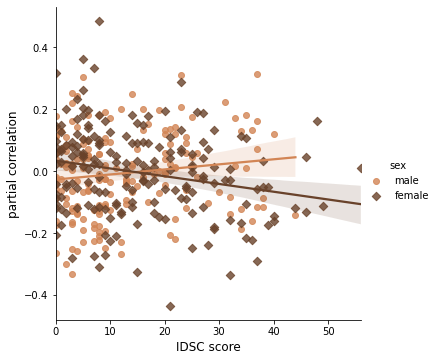

<Figure size 864x720 with 0 Axes>

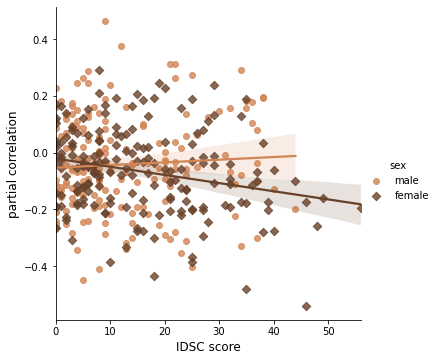

In [42]:
# plot data and regression model fits across a FacetGrid
for connection in sexdif_cons_depr:
    
    connection = connection[:-5]
    
    plt.figure(figsize=(12, 10))
    
    ax = sns.lmplot(x = 'idsc', y = connection, hue = 'sex', data = data, palette = 'copper_r', markers = ['o','D'])
    
    # costumize the legend, fontsizes, labels, title
    #plt.title(connection.replace('_',' '), fontsize = 20, pad = 20)
    ax.axes[0,0].set_ylabel('partial correlation', fontsize = 12)
    ax.axes[0,0].set_xlabel('IDSC score', fontsize = 12)
    plt.yticks(fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.subplots_adjust(bottom=0.1)
    plt.savefig(f'/media/sf_shared_VB/MA_results/idsc_{connection}_sexdif.png')

### YMRS

<Figure size 864x720 with 0 Axes>

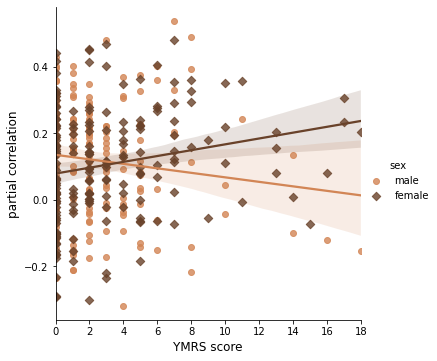

In [43]:
# plotting 
for connection in sexdif_cons_manic:
    
    connection = connection[:-5]
    
    plt.figure(figsize=(12, 10))
    
    ax = sns.lmplot(x = 'ymrs', y = connection, hue = 'sex', data = data, palette = 'copper_r', markers = ['o','D'])
    
    # costumize the legend, fontsizes, labels, title
    #plt.title(connection.replace('_',' '), fontsize = 15, pad = 20)
    ax.axes[0,0].set_ylabel('partial correlation', fontsize = 12)
    ax.axes[0,0].set_xlabel('YMRS score', fontsize = 12)
    plt.yticks(fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.subplots_adjust(bottom=0.1)
    plt.savefig(f'/media/sf_shared_VB/MA_results/ymrs_{connection}_sexdif.png')